In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
TITANIC_PATH = os.path.join("datasets", "titanic")

In [3]:
# Unzip the downloaded titanic dataset 
def load_data(data, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, data)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_data("train.csv")
test_data = load_data("test.csv")

### Example solution

In [5]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [6]:
women

1      1
2      1
3      1
8      1
9      1
      ..
880    1
882    0
885    0
887    1
888    0
Name: Survived, Length: 314, dtype: int64

In [7]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [8]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv(TITANIC_PATH+'/submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


get_dummies: Convert categorical variable into dummy/indicator variables.

### My solution
#### Checking data

In [9]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- SibSp: # of siblings / spouses aboard the Titanic
- Parch: # of parents / children aboard the Titanic
- Ticket: ticket id
- Fare: price paid in pounds
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic 

In [10]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Features Age, Cabin, Embarked include some NAN valus

In [12]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


A brife describtion of Numeric values exclude NAN values

In [13]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [14]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [15]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [16]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

#### Preprocessing pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

Machine learning algorithms don't perform well when the input numerical attributes have very different scales. We don't scale target feature.
- Age: 0-80, mean age: 29
- SibSp: 0-8, mean: 0.52
- Parch: 0-6, mean: 0.38
- Fare: 0-512, mean: 32 

SimpleImputer: Replace each numerical attribute's missing values with the median of that attributes; Replace each categorical attribute's missing values with the most frequent value of that attributes

In [18]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

In [19]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder())
])

In [20]:
num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

In [21]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [22]:
X_train = full_pipeline.fit_transform(train_data[num_attribs + cat_attribs])

In [23]:
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [24]:
y_train = train_data['Survived']

#### Training model

We will try three different methods for classification and find the best model suits this task. 
- tree-based model: random forest
- linear model fit using least-squares: linear classfier(Support vector machine)
- K-nearest Neighbors: KNN

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [26]:
# Random forest
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
X_test = full_pipeline.fit_transform(test_data[num_attribs + cat_attribs])
y_pred = rnd_clf.predict(X_test)

rnd_scores = cross_val_score(rnd_clf, X_train, y_train, cv=10)
rnd_scores.mean()

0.826067415730337

In [27]:
from sklearn.svm import SVC

In [28]:
# Support vector machine
svm_clf = SVC(gamma='auto')
svm_clf.fit(X_train, y_train)
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
# KNN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_scores.mean()

0.8069912609238452

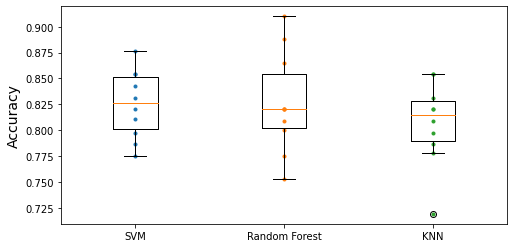

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, rnd_scores, ".")
plt.plot([3]*10, knn_scores, ".")
plt.boxplot([svm_scores, rnd_scores, knn_scores], labels=("SVM","Random Forest", "KNN"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

SVM generalizes better than other methods.

In [32]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': svm_clf.predict(X_test)})
output.to_csv(TITANIC_PATH+'/svm_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Further:
- Tune hyperparameters using grid search or cross validation
- Feature engineering: using age group to replace age, etc.